# Tutorial on MORPH

In this tutorial, we will assess the performance of a facial recognition system in a 1:1 face
verification task on the [MORPH dataset](https://uncw.edu/oic/tech/morph.html). We have obtained the
embeddings generated by the system for the images in the data and stored them in a dictionary
`df[identity name][image name] = embedding`. Below we load the dictionary.


In [1]:
import json
from cismat import MTData, UncertaintyEstimator
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df_main = json.load(open('../data/morph/embeddings.json', 'r'))
len(df_main)  # number of identities in the data

63548

We analyze the system performance in two settings:

- [_small datasets_](#computations-on-small-datasets): We assess the system performance on all pairwise comparisons between the images in the data.
- [_large datasets_](#computations-on-massive-datasets): We compute the system performance on a subset of all pairwise comparisons between the images in the data.

We compute confidence intervals for error metrics for a given score threshold as well as pointwise intervals for the ROC using the Wilson method, the double-or-nothing bootstrap, and the vertexex bootstrap.


## Computations on small datasets


Let's first look at how to construct confidence intervals for error rates on small datasets. here we consider only 50 IDs in the data and we compute the error metrics on this small dataset. 


In [3]:
# subset the IDs
ids = random.sample(list(df_main.keys()), 50)
df = {id: df_main[id] for id in ids}
len(df)

50

In [4]:
# compute cosine similarity between IDs
mt = MTData(df)
mt.generate_similarity_scores()

We now show how to construct

- confidence intervals for error metrics that are computed by fixing the threshold used to turn scores into binary predictions.
- pointwise confidence intervals for the ROC.


### Confidence intervals for error metrics at a fixed threshold


In [5]:
threshold = 0.9 # set a threshold
uq = UncertaintyEstimator(scores=mt.similarity_scores)
fnr, fpr, _ = uq.compute_binerror_metrics(threshold)
fnr, fpr # FNMR, FMR

(0.213149978513107, 0.18793783718495854)

In [6]:
# Estimate the variance of FNMR and FMR using a plug-in estimator
var_fnr, var_fpr = uq.compute_variance(threshold=threshold, estimator="plugin")
ci_fnr, ci_fpr = uq.get_binerror_ci(threshold=threshold, var_fnr=var_fnr, var_fpr=var_fpr, alpha=0.1)
ci_fnr, ci_fpr 

ci_fnr, ci_fpr

([0.13596698694203785, 0.31802036578522125],
 [0.15527244027167408, 0.2256395990808476])

In [7]:
# Perform bootstrap estimation to get variance estimates
uq.run_bootstrap(B=1000)  # B is the number of bootstrap samples
# Estimate variance using the double-or-nothing bootstrap
var_fnr_boot, var_fpr_boot = uq.compute_variance(threshold=threshold, estimator="boot")
ci_fnr_boot, ci_fpr_boot = uq.get_binerror_ci(threshold=threshold, var_fnr=var_fnr_boot, var_fpr=var_fpr_boot, alpha=0.1)
ci_fnr_boot, ci_fpr_boot

100%|██████████| 1000/1000 [00:08<00:00, 117.86it/s]


([0.12176663189727249, 0.34608855803380895],
 [0.14011954282096595, 0.2473801865679788])

The bootstrap may take some time to run but remember that once it's done you can get a lot of uncertainty measures (almost) for free!

### Pointwise confidence intervals for the ROC


In [8]:
# intervals for FNMR @ FMR = 1e-4, 1e-3, 1e-2, 1e-2, 1 with the double-or-nothing bootstrap
target_fpr = [0.0001, 0.001, 0.01, 0.1, 1]
fpr, tpr, auc = uq.get_roc(target_fpr = target_fpr)
ci_roc_dbn, ci_auc_dbn = uq.get_roc_ci(target_fpr=target_fpr, alpha = 0.1)

In [9]:
for i in range(len(target_fpr)):
    ci = (ci_roc_dbn[0][i], ci_roc_dbn[1][i])
    print(f" FNMR = {(1 - tpr[i]):.2f} @ FMR = {target_fpr[i]:.2f} has 90% CI: ({(1 - ci[1]):.2f}, {(1 - ci[0]):.2f})")

 FNMR = 0.84 @ FMR = 0.00 has 90% CI: (0.65, 0.92)
 FNMR = 0.68 @ FMR = 0.00 has 90% CI: (0.41, 0.79)
 FNMR = 0.38 @ FMR = 0.01 has 90% CI: (0.19, 0.53)
 FNMR = 0.26 @ FMR = 0.10 has 90% CI: (0.13, 0.34)
 FNMR = 0.00 @ FMR = 1.00 has 90% CI: (0.00, 0.00)


In [10]:
# auc confidence interval
ci_auc_dbn

array([0.88268817, 0.95518777])

In [11]:
# intervals across the entire range of FMR values
fpr, tpr, auc = uq.get_roc()
ci_roc_dbn, ci_auc_dbn = uq.get_roc_ci(alpha = 0.1)

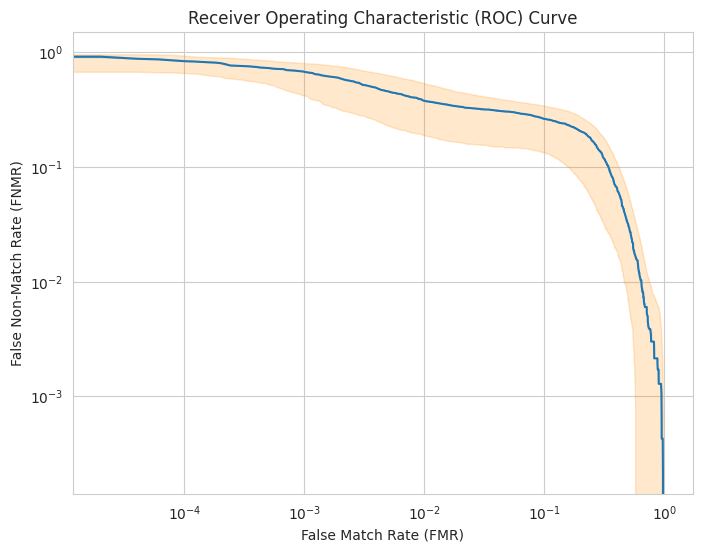

In [12]:
# plot the ROC curve with the double-or-nothing bootstrap intervals
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x = "fpr", y = "fnr", data = pd.DataFrame({"fpr": fpr, "fnr": 1 - tpr}))
plt.fill_between(fpr, 1 - ci_roc_dbn[1],1 - ci_roc_dbn[0], alpha=0.2, color='darkorange', label='')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Computations on massive datasets


In [13]:
# load the dataset again
df = df_main

In [14]:
# how many observations are there in the dataset?
# total observations for fnmr computations
print(sum([len(df[id]) * (len(df[id]) - 1) / 2 for id in df]))
# m_by_id = [len(df[id]) for id in df] # total observations for fmr computations
# print(sum([m_by_id[i] * sum([m_by_id[j] for j in range(len(m_by_id)) if j != i]) for i in range(len(m_by_id))]) / 2)


3001005.0


We first set a budget, that is we decide the maximum number of pairwise comparisons that we can take into account in the computations of error metrics and confidence intervals given our computational resources. We will then randomly pick the combinations of identities and corresponding images to be used.  

In [15]:
def pick_random_combs(df, budget_fnmr, budget_fmr):
    identities = list(df.keys())

    # not sampling from the full list of (identity, image) pairs because the number is too large
    # if dataset is very imbalanced, sampling from the full list (or as below 
    # but with weights proportional to the number of images per identity) 
    # is better to avoid picking the same identities with few images over and over again
    combs_fmr = set()
    while budget_fmr > 0:
        idc1, idc2 = random.sample(identities, k=2)
        imgc1, imgc2 = random.sample(list(df[idc1]), k=1)[
            0], random.sample(list(df[idc2]), k=1)[0]
        if (idc1, imgc1, idc2, imgc2) not in combs_fmr and (idc1, imgc1, idc2, imgc2) not in combs_fmr and idc1 != idc2:
            combs_fmr.add((idc1, imgc1, idc2, imgc2))
            budget_fmr -= 1

    combs_fnmr = set()
    while budget_fnmr > 0:
        idc1 = random.sample(identities, k=1)[0]
        imgs = list(df[idc1])
        if len(imgs) > 2:
            imgc1, imgc2 = random.sample(imgs, k=2)

            if (idc1, imgc1, idc1, imgc2) not in combs_fnmr and (idc1, imgc1, idc1, imgc2) not in combs_fnmr:
                combs_fnmr.add((idc1, imgc1, idc1, imgc2))
                budget_fnmr -= 1

    return combs_fnmr, combs_fmr

budget = 1e4
fnmr_pairs, fmr_pairs = pick_random_combs(df, budget, budget)
combs = set(fnmr_pairs).union(fmr_pairs)


In [16]:
# compute distances for the pairs in the protocols
mt = MTData(df)
mt.generate_similarity_scores(pairs = combs)
len(mt.similarity_scores)

23775

In [17]:
threshold = 0.9
uq = UncertaintyEstimator(scores=mt.similarity_scores)
fnr, fpr, _ = uq.compute_binerror_metrics(threshold)
fnr, fpr # FNMR, FMR

(0.1591, 0.2195)

### Confidence intervals for error metrics at a fixed threshold

We now compute Wilson and bootstrap confidence intervals.


In [18]:
# Estimate the variance of FNMR and FMR estimates using a plug-in estimator
var_fnr, var_fpr = uq.compute_variance(threshold=threshold, estimator="plugin")
ci_fnr, ci_fpr = uq.get_binerror_ci(threshold=threshold, var_fnr=var_fnr, var_fpr=var_fpr, alpha=0.1)
ci_fnr, ci_fpr 

ci_fnr, ci_fpr

([0.1529887235120624, 0.16540772425516329],
 [0.21261172295959074, 0.2265472359396937])

In [19]:
# Perform bootstrap estimation to get variance estimates (parallelize the function to increase speed)
uq.run_bootstrap(B=1000)
# Estimate variance using the double-or-nothing bootstrap
var_fnr_boot, var_fpr_boot = uq.compute_variance(threshold=threshold, estimator="boot")
ci_fnr_boot, ci_fpr_boot = uq.get_binerror_ci(threshold=threshold, var_fnr=var_fnr_boot, var_fpr=var_fpr_boot, alpha=0.1)
ci_fnr_boot, ci_fpr_boot

100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


([0.1528282344435864, 0.1655788414935312],
 [0.20765398447334862, 0.23182407514971076])

### Pointwise confidence intervals for the ROC


In [20]:
# intervals across the entire range of FMR values
fpr, tpr, auc = uq.get_roc()
ci_roc_dbn, ci_auc_dbn = uq.get_roc_ci(alpha = 0.1)

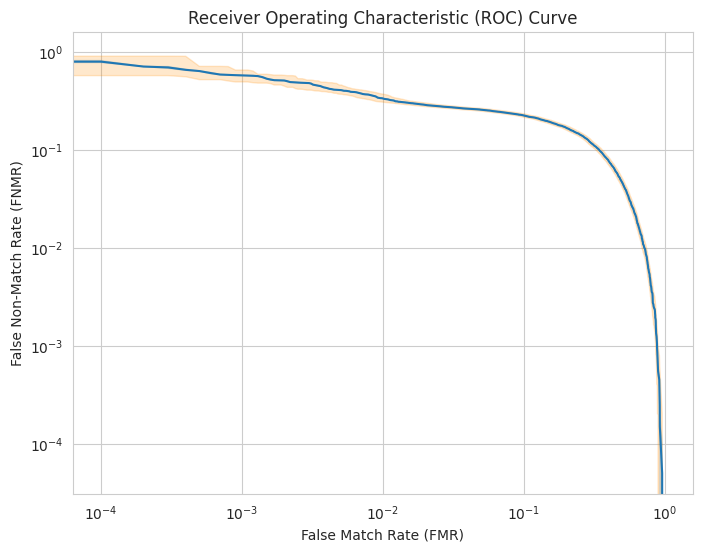

In [21]:
# plot the ROC curve with the double-or-nothing bootstrap intervals
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x = "fpr", y = "fnr", data = pd.DataFrame({"fpr": fpr, "fnr": 1 - tpr}))
plt.fill_between(fpr, 1 - ci_roc_dbn[1],1 - ci_roc_dbn[0], alpha=0.2, color='darkorange', label='')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xscale('log')
plt.yscale('log')
plt.show()